In [1]:
# Install required libraries
!pip install kaggle transformers torchaudio scikit-learn seaborn matplotlib

# Import files for upload
from google.colab import files

# Prompt for kaggle.json upload
print("Please upload your kaggle.json file")
uploaded = files.upload()

# Set up Kaggle directory and permissions
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset
print("Downloading the dataset")
!kaggle datasets download -d ikrbasak/sep-28k

# Unzip the downloaded file
print("Unzipping the file")
!unzip -q sep-28k.zip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 87.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 57.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 98.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/ikrbasak/sep-28k
License(s): Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)
 99% 2.16G/2.17G [00:51<00:00, 45.1MB/s]
100% 2.17G/2.17G [00:51<00:00, 45.4MB/s]
Unzipping the file


In [2]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

# Data Loading and Cleaning
print("Loading and combining datasets")
clips_dir = 'clips/stuttering-clips/clips'
sep_labels_df = pd.read_csv('SEP-28k_labels.csv')
fluency_labels_df = pd.read_csv('fluencybank_labels.csv')
combined_df = pd.concat([sep_labels_df, fluency_labels_df], ignore_index=True)

print("Processing labels and cleaning data")
stutter_columns = ['Prolongation', 'Block', 'SoundRep', 'WordRep', 'Interjection']
all_event_columns = stutter_columns + ['NoStutteredWords']
combined_df['label'] = combined_df[all_event_columns].idxmax(axis=1)
clean_df = combined_df[(combined_df['PoorAudioQuality'] == 0) & (combined_df['Music'] == 0) & (combined_df['NoSpeech'] == 0)].copy()

def generate_correct_path(row):
    filename = f"{row['Show']}_{row['EpId']}_{row['ClipId']}.wav"
    return os.path.join(clips_dir, filename)

clean_df['file_path'] = clean_df.apply(generate_correct_path, axis=1)
final_df = clean_df[clean_df['file_path'].apply(os.path.exists)].copy()

# Subsetting for speed
print(f"Original number of clips: {len(final_df)}")
final_df = final_df.sample(n=4000, random_state=42)
print(f"Using a subset of {len(final_df)} clips for fast training")

# Final Preparation
label_encoder = LabelEncoder()
final_df['encoded_label'] = label_encoder.fit_transform(final_df['label'])
X = final_df['file_path'].values
y = final_df['encoded_label'].values
num_classes = len(label_encoder.classes_)

# Create Train, Validation, and Test splits (80%, 10%, 10%)
X_train_paths, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val_paths, X_test_paths, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print("Data preprocessing complete.")
print(f"Train samples: {len(X_train_paths)}, Validation samples: {len(X_val_paths)}, Test samples: {len(X_test_paths)}")

Loading and combining datasets
Processing labels and cleaning data
Original number of clips: 26098
Using a subset of 4000 clips for fast training
Data preprocessing complete.
Train samples: 3200, Validation samples: 400, Test samples: 400


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Function to plot training history
def plot_metrics(history, model_name):
    print(f"Plotting metrics for {model_name}")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.plot(history['train_loss'], label='Train Loss')
    ax1.plot(history['val_loss'], label='Validation Loss')
    ax1.set_title(f'{model_name} Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    ax2.plot(history['train_acc'], label='Train Accuracy')
    ax2.plot(history['val_acc'], label='Validation Accuracy')
    ax2.set_title(f'{model_name} Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    plt.show()

# Function to evaluate CNN-based models on the test set
def evaluate_cnn_model(model, model_path, test_loader, device, label_encoder):
    print(f"Evaluating model from {model_path} on the test set")
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()

    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Print metrics
    class_names = label_encoder.classes_
    print("Test Accuracy:", accuracy_score(all_labels, all_preds))
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

Phase 1: Training ResNet18


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 95.0MB/s]


ResNet Epoch 1/3, Val Acc: 31.50%
New best ResNet model saved
ResNet Epoch 2/3, Val Acc: 33.00%
ResNet Epoch 3/3, Val Acc: 25.50%
Phase 1 Complete
Plotting metrics for ResNet18


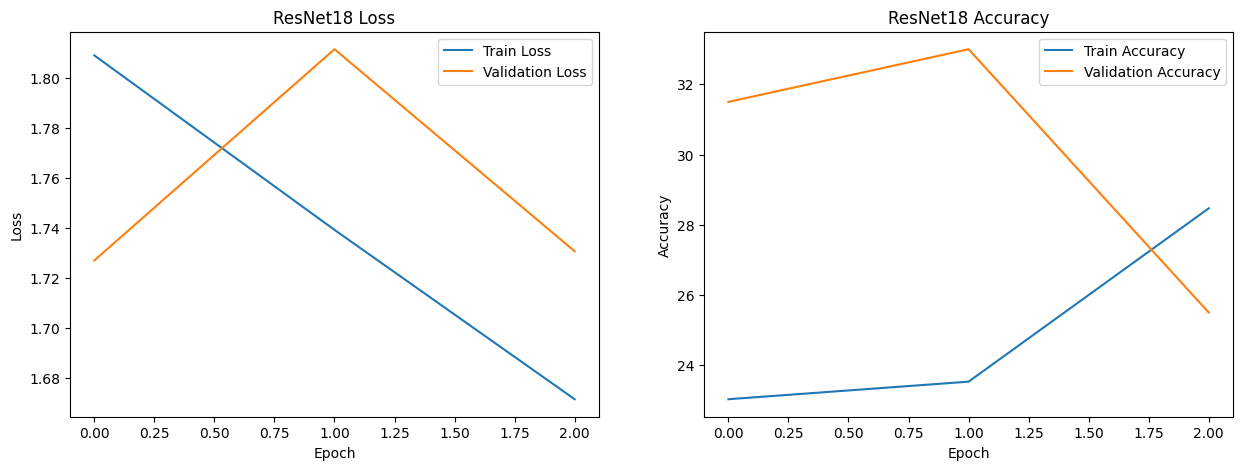

Evaluating model from best_resnet_model.pth on the test set
Test Accuracy: 0.3175

Classification Report:
                  precision    recall  f1-score   support

           Block       0.00      0.00      0.00        48
    Interjection       0.31      0.52      0.38        58
NoStutteredWords       0.55      0.37      0.44       180
    Prolongation       0.71      0.10      0.18        49
        SoundRep       0.14      0.35      0.20        26
         WordRep       0.15      0.41      0.22        39

        accuracy                           0.32       400
       macro avg       0.31      0.29      0.24       400
    weighted avg       0.40      0.32      0.31       400



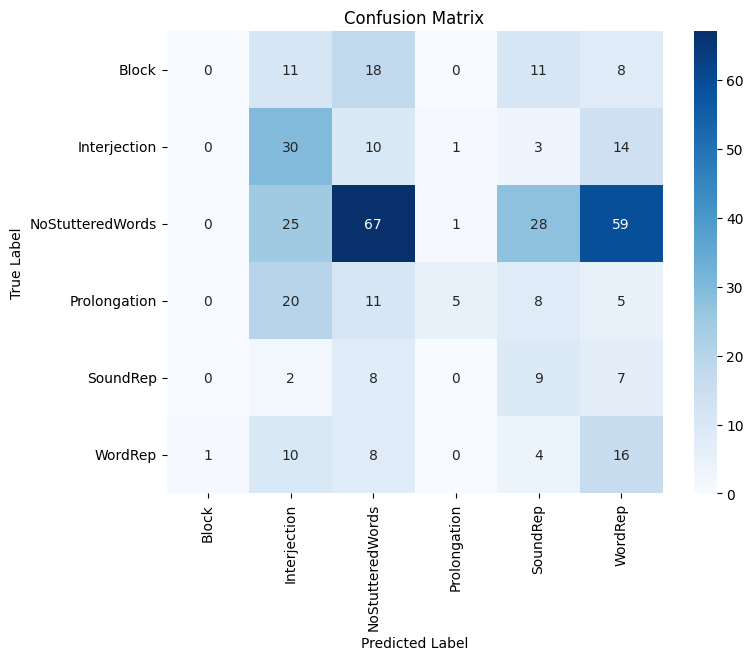

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import librosa

# Dataset for Spectrograms
class SpectrogramDataset(Dataset):
    def __init__(self, file_paths, labels):
        self.file_paths, self.labels, self.sr, self.n_mels, self.max_pad_len = file_paths, labels, 16000, 128, 188
    def __len__(self): return len(self.file_paths)
    def __getitem__(self, idx):
        path, label = self.file_paths[idx], self.labels[idx]
        audio, _ = librosa.load(path, sr=self.sr)
        if len(audio) == 0: mel_db = np.zeros((self.n_mels, self.max_pad_len), dtype=np.float32)
        else:
            mel = librosa.feature.melspectrogram(y=audio, sr=self.sr, n_mels=self.n_mels)
            mel_db = librosa.power_to_db(mel, ref=np.max)
            if mel_db.shape[1] > self.max_pad_len: mel_db = mel_db[:, :self.max_pad_len]
            else: mel_db = np.pad(mel_db, ((0, 0), (0, self.max_pad_len - mel_db.shape[1])), mode='constant')
        mel_db = np.stack([mel_db, mel_db, mel_db], axis=0)
        return torch.tensor(mel_db, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

# Model, DataLoaders, and Training Loop
print("Phase 1: Training ResNet18")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_dataset = SpectrogramDataset(X_train_paths, y_train)
val_dataset = SpectrogramDataset(X_val_paths, y_val)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

resnet_model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, num_classes)
resnet_model = resnet_model.to(device)

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float).to(device))
optimizer = torch.optim.Adam(resnet_model.parameters(), lr=0.001)
best_val_loss = float('inf')
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for epoch in range(3):
    resnet_model.train()
    train_loss, correct_train, total_train = 0.0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = resnet_model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0); correct_train += (predicted == labels).sum().item()

    resnet_model.eval()
    val_loss, correct_val, total_val = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = resnet_model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0); correct_val += (predicted == labels).sum().item()

    # Store metrics
    history['train_loss'].append(train_loss / len(train_loader))
    history['train_acc'].append(100 * correct_train / total_train)
    epoch_val_loss = val_loss / len(val_loader)
    history['val_loss'].append(epoch_val_loss)
    history['val_acc'].append(100 * correct_val / total_val)
    print(f'ResNet Epoch {epoch+1}/3, Val Acc: {history["val_acc"][-1]:.2f}%')
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        torch.save(resnet_model.state_dict(), 'best_resnet_model.pth')
        print(f"New best ResNet model saved")

print("Phase 1 Complete")
plot_metrics(history, "ResNet18")
test_dataset = SpectrogramDataset(X_test_paths, y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)
evaluate_cnn_model(resnet_model, 'best_resnet_model.pth', test_loader, device, label_encoder)

Phase 2: Training CRNN
CRNN Epoch 1/3, Val Acc: 11.50%
New best CRNN model saved
CRNN Epoch 2/3, Val Acc: 12.00%
New best CRNN model saved
CRNN Epoch 3/3, Val Acc: 11.00%
New best CRNN model saved
Phase 2 Complete
Plotting metrics for CRNN


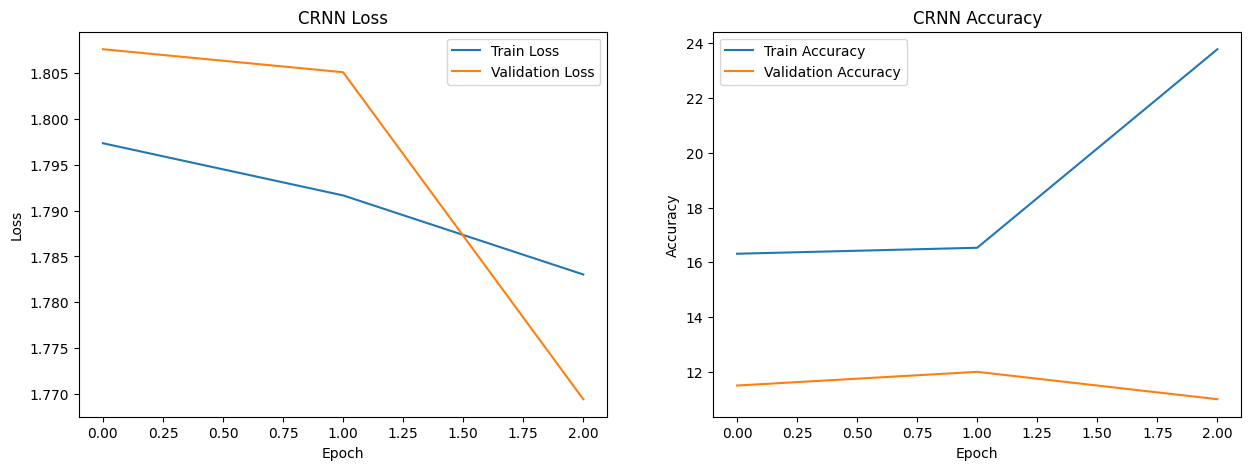

Evaluating model from best_crnn_model.pth on the test set
Test Accuracy: 0.115

Classification Report:
                  precision    recall  f1-score   support

           Block       0.08      0.19      0.11        48
    Interjection       0.16      0.31      0.21        58
NoStutteredWords       0.00      0.00      0.00       180
    Prolongation       0.00      0.00      0.00        49
        SoundRep       0.00      0.00      0.00        26
         WordRep       0.11      0.49      0.18        39

        accuracy                           0.12       400
       macro avg       0.06      0.16      0.08       400
    weighted avg       0.04      0.12      0.06       400



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


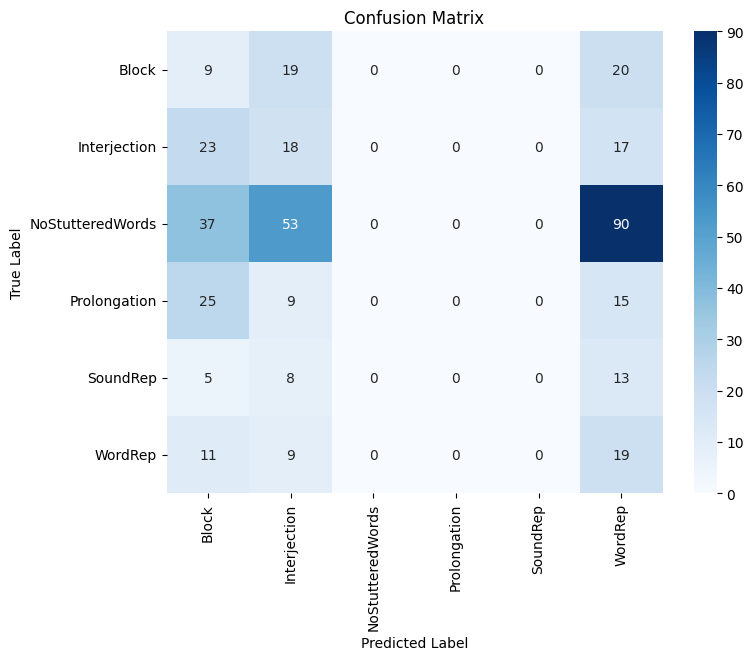

In [6]:
import torch
import torch.nn as nn
import torchvision.models as models

# CRNN Model Definition
class CRNN(nn.Module):
    def __init__(self, num_classes):
        super(CRNN, self).__init__()
        resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        self.cnn = nn.Sequential(*list(resnet.children())[:-2])

        # THIS IS THE FIX: The LSTM now correctly expects an input size of 2048.
        self.lstm = nn.LSTM(input_size=2048, hidden_size=128, num_layers=2, bidirectional=True, batch_first=True)

        self.fc = nn.Linear(128 * 2, num_classes) # *2 for bidirectional

    def forward(self, x):
        # Pass through CNN
        x = self.cnn(x)
        # Reshape for LSTM: (batch, channels, height, width) -> (batch, width, features)
        x = x.permute(0, 3, 1, 2)
        x = x.flatten(2)
        # Pass through LSTM
        x, _ = self.lstm(x)
        # Get the output of the last time step
        x = self.fc(x[:, -1, :])
        return x

# Training Loop
print("Phase 2: Training CRNN")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
crnn_model = CRNN(num_classes).to(device)
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float).to(device))
optimizer = torch.optim.Adam(crnn_model.parameters(), lr=0.001)
best_val_loss = float('inf')
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for epoch in range(3):
    crnn_model.train()
    train_loss, correct_train, total_train = 0.0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = crnn_model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0); correct_train += (predicted == labels).sum().item()

    crnn_model.eval()
    val_loss, correct_val, total_val = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = crnn_model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0); correct_val += (predicted == labels).sum().item()

    history['train_loss'].append(train_loss / len(train_loader))
    history['train_acc'].append(100 * correct_train / total_train)
    epoch_val_loss = val_loss / len(val_loader)
    history['val_loss'].append(epoch_val_loss)
    history['val_acc'].append(100 * correct_val / total_val)
    print(f'CRNN Epoch {epoch+1}/3, Val Acc: {history["val_acc"][-1]:.2f}%')
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        torch.save(crnn_model.state_dict(), 'best_crnn_model.pth')
        print(f"New best CRNN model saved")

print("Phase 2 Complete")
plot_metrics(history, "CRNN")
# Re-use test loader from Phase 1
evaluate_cnn_model(crnn_model, 'best_crnn_model.pth', test_loader, device, label_encoder)

Phase 3: Training Transformer


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.84k [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:312: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/380M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/380M [00:00<?, ?B/s]

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/models/wav2vec2/feature_extraction_wav2vec2.py:98: RuntimeWarning: Mean of empty slice.
  normed_input_values = [(x - x.mean()) / np.sqrt(x.var() + 1e-7) for x in input_values]
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.11/dist-packages/transformers/models/wav2vec2/feature_extraction_wav2vec2.py:98: RuntimeWarning: Degrees of freedom <= 0 for slice
  normed_input_values = [(x - x.mean()) / np.sqrt(x.var() + 1e-7) for x in input_values]
/usr/local/lib/python3.11/dis

Wav2Vec2 Epoch 1/3, Val Acc: 45.25%
New best Wav2Vec2 model saved
Wav2Vec2 Epoch 2/3, Val Acc: 45.25%
New best Wav2Vec2 model saved
Wav2Vec2 Epoch 3/3, Val Acc: 45.25%
New best Wav2Vec2 model saved
Phase 3 Complete
Plotting metrics for Wav2Vec2


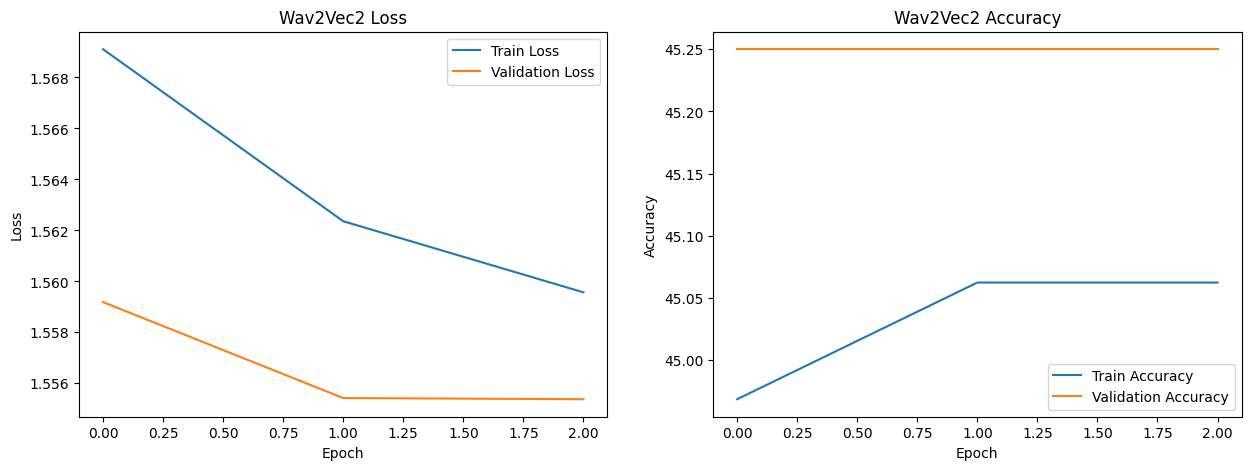

Evaluating model from best_wav2vec_model.pth on the test set
Test Accuracy: 0.45

Classification Report:
                  precision    recall  f1-score   support

           Block       0.00      0.00      0.00        48
    Interjection       0.00      0.00      0.00        58
NoStutteredWords       0.45      1.00      0.62       180
    Prolongation       0.00      0.00      0.00        49
        SoundRep       0.00      0.00      0.00        26
         WordRep       0.00      0.00      0.00        39

        accuracy                           0.45       400
       macro avg       0.07      0.17      0.10       400
    weighted avg       0.20      0.45      0.28       400



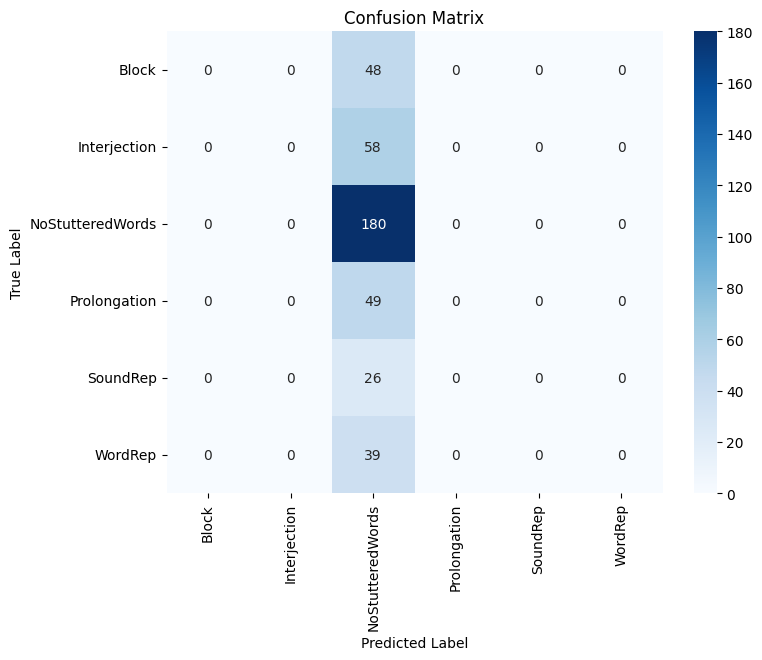

In [7]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2ForSequenceClassification
import librosa

# Dataset for Raw Audio
class Wav2VecDataset(Dataset):
    def __init__(self, file_paths, labels, feature_extractor):
        self.file_paths, self.labels, self.feature_extractor, self.sr = file_paths, labels, feature_extractor, 16000
    def __len__(self): return len(self.file_paths)
    def __getitem__(self, idx):
        path, label = self.file_paths[idx], self.labels[idx]
        audio, _ = librosa.load(path, sr=self.sr)
        inputs = self.feature_extractor(audio, sampling_rate=self.sr, return_tensors="pt", padding=True)
        inputs['input_values'] = inputs['input_values'].squeeze(0)
        return inputs, torch.tensor(label, dtype=torch.long)

def collate_fn(batch):
    inputs = [item[0] for item in batch]
    labels = [item[1] for item in batch]
    return feature_extractor.pad(inputs, return_tensors='pt'), torch.stack(labels)

# Model, DataLoaders, and Training Loop
print("Phase 3: Training Transformer")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "facebook/wav2vec2-base"
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(model_name)
wav2vec_model = Wav2Vec2ForSequenceClassification.from_pretrained(model_name, num_labels=num_classes).to(device)

train_dataset_w2v = Wav2VecDataset(X_train_paths, y_train, feature_extractor)
val_dataset_w2v = Wav2VecDataset(X_val_paths, y_val, feature_extractor)
train_loader_w2v = DataLoader(train_dataset_w2v, batch_size=8, shuffle=True, collate_fn=collate_fn)
val_loader_w2v = DataLoader(val_dataset_w2v, batch_size=8, shuffle=False, collate_fn=collate_fn)

optimizer = torch.optim.AdamW(wav2vec_model.parameters(), lr=5e-5)
best_val_loss = float('inf')
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for epoch in range(3):
    wav2vec_model.train()
    train_loss, correct_train, total_train = 0.0, 0, 0
    for inputs, labels in train_loader_w2v:
        inputs = {k: v.to(device) for k, v in inputs.items()}
        labels = labels.to(device)
        outputs = wav2vec_model(**inputs, labels=labels)
        loss = outputs.loss
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs.logits, 1)
        total_train += labels.size(0); correct_train += (predicted == labels).sum().item()

    wav2vec_model.eval()
    val_loss, correct_val, total_val = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader_w2v:
            inputs = {k: v.to(device) for k, v in inputs.items()}
            labels = labels.to(device)
            outputs = wav2vec_model(**inputs, labels=labels)
            loss = outputs.loss
            val_loss += loss.item()
            _, predicted = torch.max(outputs.logits, 1)
            total_val += labels.size(0); correct_val += (predicted == labels).sum().item()

    history['train_loss'].append(train_loss / len(train_loader_w2v))
    history['train_acc'].append(100 * correct_train / total_train)
    epoch_val_loss = val_loss / len(val_loader_w2v)
    history['val_loss'].append(epoch_val_loss)
    history['val_acc'].append(100 * correct_val / total_val)
    print(f'Wav2Vec2 Epoch {epoch+1}/3, Val Acc: {history["val_acc"][-1]:.2f}%')
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        torch.save(wav2vec_model.state_dict(), 'best_wav2vec_model.pth')
        print(f"New best Wav2Vec2 model saved")

print("Phase 3 Complete")
plot_metrics(history, "Wav2Vec2")

# Evaluation for Wav2Vec2 model
print(f"Evaluating model from best_wav2vec_model.pth on the test set")
test_dataset_w2v = Wav2VecDataset(X_test_paths, y_test, feature_extractor)
test_loader_w2v = DataLoader(test_dataset_w2v, batch_size=8, shuffle=False, collate_fn=collate_fn)
wav2vec_model.load_state_dict(torch.load('best_wav2vec_model.pth'))
wav2vec_model.to(device)
wav2vec_model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in test_loader_w2v:
        inputs = {k: v.to(device) for k, v in inputs.items()}
        outputs = wav2vec_model(**inputs)
        _, predicted = torch.max(outputs.logits, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

class_names = label_encoder.classes_
print("Test Accuracy:", accuracy_score(all_labels, all_preds))
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

Phase 4: Ensemble Evaluation
Loading best saved models


/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:312: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Performing ensemble prediction on the test set


/usr/local/lib/python3.11/dist-packages/transformers/models/wav2vec2/feature_extraction_wav2vec2.py:98: RuntimeWarning: Mean of empty slice.
  normed_input_values = [(x - x.mean()) / np.sqrt(x.var() + 1e-7) for x in input_values]
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.11/dist-packages/transformers/models/wav2vec2/feature_extraction_wav2vec2.py:98: RuntimeWarning: Degrees of freedom <= 0 for slice
  normed_input_values = [(x - x.mean()) / np.sqrt(x.var() + 1e-7) for x in input_values]
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:175: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:210: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Ensemble Evaluation Results
Test Accuracy: 0.46

Classification Report:
                  precision    recall  f1-score   support

           Block       0.00      0.00      0.00        48
    Interjection       0.60      0.05      0.10        58
NoStutteredWords       0.46      1.00      0.63       180
    Prolongation       1.00      0.02      0.04        49
        SoundRep       0.00      0.00      0.00        26
         WordRep       0.00      0.00      0.00        39

        accuracy                           0.46       400
       macro avg       0.34      0.18      0.13       400
    weighted avg       0.42      0.46      0.30       400



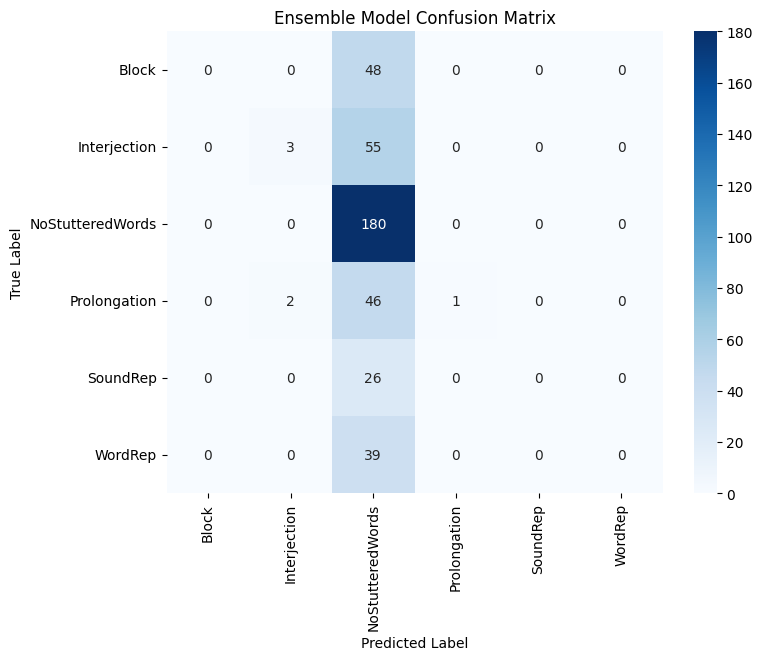

Phase 4 Complete


In [8]:
import torch
import torch.nn as nn
import torchvision.models as models
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2ForSequenceClassification
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# This assumes all previous model definitions (CRNN) and data loaders are available
print("Phase 4: Ensemble Evaluation")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Load all three best models
print("Loading best saved models")

# Load ResNet
resnet_ensemble = models.resnet18()
resnet_ensemble.fc = nn.Linear(resnet_ensemble.fc.in_features, num_classes)
resnet_ensemble.load_state_dict(torch.load('best_resnet_model.pth'))
resnet_ensemble.to(device)
resnet_ensemble.eval()

# Load CRNN
crnn_ensemble = CRNN(num_classes)
crnn_ensemble.load_state_dict(torch.load('best_crnn_model.pth'))
crnn_ensemble.to(device)
crnn_ensemble.eval()

# Load Wav2Vec2
model_name = "facebook/wav2vec2-base"
wav2vec_ensemble = Wav2Vec2ForSequenceClassification.from_pretrained(model_name, num_labels=num_classes)
wav2vec_ensemble.load_state_dict(torch.load('best_wav2vec_model.pth'))
wav2vec_ensemble.to(device)
wav2vec_ensemble.eval()

# 2. Prepare the two types of test dataloaders
# CNN-based models need spectrograms
test_dataset_cnn = SpectrogramDataset(X_test_paths, y_test)
test_loader_cnn = DataLoader(test_dataset_cnn, batch_size=8, shuffle=False, num_workers=2)

# Wav2Vec2 needs raw audio
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(model_name)
test_dataset_w2v = Wav2VecDataset(X_test_paths, y_test, feature_extractor)
test_loader_w2v = DataLoader(test_dataset_w2v, batch_size=8, shuffle=False, collate_fn=collate_fn)

# 3. Perform Ensemble Prediction
print("Performing ensemble prediction on the test set")
all_ensemble_preds = []
all_labels = []

with torch.no_grad():
    # Iterate through both loaders simultaneously
    for (cnn_inputs, cnn_labels), (w2v_inputs, _) in zip(test_loader_cnn, test_loader_w2v):

        # Move data to GPU
        cnn_inputs = cnn_inputs.to(device)
        w2v_inputs = {k: v.to(device) for k, v in w2v_inputs.items()}
        labels = cnn_labels.to(device) # Labels are the same

        # Get logits (raw model scores)
        resnet_logits = resnet_ensemble(cnn_inputs)
        crnn_logits = crnn_ensemble(cnn_inputs)
        wav2vec_outputs = wav2vec_ensemble(**w2v_inputs)
        wav2vec_logits = wav2vec_outputs.logits

        # Convert logits to probabilities (confidence scores)
        resnet_probs = torch.softmax(resnet_logits, dim=1)
        crnn_probs = torch.softmax(crnn_logits, dim=1)
        wav2vec_probs = torch.softmax(wav2vec_logits, dim=1)

        # Average the probabilities from the three models
        avg_probs = (resnet_probs + crnn_probs + wav2vec_probs) / 3.0

        # Get final prediction from the highest average probability
        _, final_preds = torch.max(avg_probs, 1)

        all_ensemble_preds.extend(final_preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 4. Evaluate the Ensemble Model
print("Ensemble Evaluation Results")
class_names = label_encoder.classes_
print("Test Accuracy:", accuracy_score(all_labels, all_ensemble_preds))
print("\nClassification Report:")
print(classification_report(all_labels, all_ensemble_preds, target_names=class_names, zero_division=0))

cm = confusion_matrix(all_labels, all_ensemble_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Ensemble Model Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()
print("Phase 4 Complete")